In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

import os
import pickle
from time import time
from sklearn.decomposition import PCA

In [3]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
# training set - read in filenames and logspace flux values
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]    
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

In [4]:
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)
eigenseds.shape

done in 0.172s


(40, 400)

In [5]:
fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(18):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)

In [6]:
dictionary=np.load("../grid_metadata/dictionary.npy")

In [7]:
def load_pcwpar(weight):
    p=[]
    w=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
    
    return p,w

In [19]:
X, y = load_pcwpar(0)

In [21]:
kernel =  ConstantKernel(constant_value=np.var(y), constant_value_bounds=(1e1,1e6))*\
        RBF(length_scale=900,length_scale_bounds=(200,2000))*\
        RBF(length_scale=1,length_scale_bounds=(0.2,3))*\
        RBF(length_scale=1,length_scale_bounds=(0.3,4))*\
        RBF(length_scale=0.8,length_scale_bounds=(0.15,1.5))*\
        RBF(length_scale=0.08,length_scale_bounds=(0.03,0.4))*\
        RBF(length_scale=0.5,length_scale_bounds=(0.1,1))*\
        RBF(length_scale=1,length_scale_bounds=(0.2,2))*\
        RBF(length_scale=0.2,length_scale_bounds=(0.05,0.5))*\
        RBF(length_scale=0.5,length_scale_bounds=(0.2,4))*\
        RBF(length_scale=0.2,length_scale_bounds=(0.05,1.5))*\
        RBF(length_scale=0.25,length_scale_bounds=(0.08,1.5))*\
        RBF(length_scale=0.25,length_scale_bounds=(0.08,0.8))*\
        RBF(length_scale=0.5,length_scale_bounds=(0.2,4))*\
        RBF(length_scale=0.4,length_scale_bounds=(0.2,2))*\
        RBF(length_scale=5,length_scale_bounds=(3,25))

In [22]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,n_restarts_optimizer=10)

In [23]:
t0 = time()
gp.fit(X,y)
print("done in %0.3fs" % (time() - t0))

done in 2549.888s


In [24]:
print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


Learned kernel: 91.8**2 * RBF(length_scale=626) * RBF(length_scale=0.423) * RBF(length_scale=0.559) * RBF(length_scale=0.542) * RBF(length_scale=0.205) * RBF(length_scale=0.68) * RBF(length_scale=0.698) * RBF(length_scale=0.351) * RBF(length_scale=0.301) * RBF(length_scale=1.35) * RBF(length_scale=0.183) * RBF(length_scale=0.104) * RBF(length_scale=2.01) * RBF(length_scale=0.666) * RBF(length_scale=7.13)
Log-marginal-likelihood: -22861.991


In [25]:
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))

In [26]:
sl=[]
for i in range(11):
    x=[steps[0][i]]
    for j in range(len(ranges)-1):
        x.append(steps[j+1][5])
    sl.append(x)

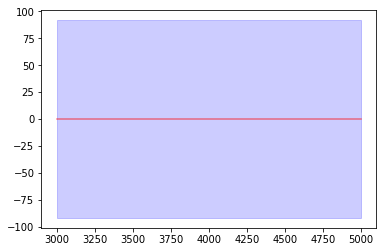

In [27]:
pred, pred_std = gp.predict(sl, return_std=True)

plt.fill_between(np.array(sl)[:,0], pred - pred_std, pred + pred_std,
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,0], pred, "r", lw=1.5, alpha=0.5)

In [ ]:
#VISUALIZATION: VIOLIN PLOTS
#    https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57
        
#import seaborn as sns
        
#Violin Plots
#f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
#f.suptitle('Wine Quality - Sulphates Content', fontsize=14)

#sns.violinplot(x="quality", y="sulphates", data=wines,  ax=ax)
#ax.set_xlabel("Wine Quality",size = 12,alpha=0.8)
#ax.set_ylabel("Wine Sulphates",size = 12,alpha=0.8)